In [ ]:
!pip install gym_minigrid
!pip install stable_baselines3
!pip install --upgrade --quiet cloudpickle pickle5
custom_objects = {
    "lr_schedule": lambda x: .003,
    "clip_range": lambda x: .02
}

In [60]:
from gym_minigrid.wrappers import *
from gym_minigrid.minigrid import *
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

import torch.nn as nn
import numpy as np

import itertools
import random

import matplotlib.pyplot as plt
%matplotlib notebook

# Info

#### Colors:
   * Red - 0
   * Green - 1
   * Blue - 2
   * Purple - 3
   * Yellow - 4
   * Grey - 5    

# Environments

## Vanilla environment for the first agent

In [2]:
class EmptyBallRoom(MiniGridEnv):
    def __init__(self, size=9, ball_color="green", tile_size=8):
        self.ball_color = ball_color
        self.tile_size = tile_size
        super().__init__(
            grid_size=size,
            max_steps=4*size*size,
            # Set this to True for maximum speed
            see_through_walls=True
        )
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(size * tile_size, size * tile_size, 3),
            dtype='uint8'
        )
    
    def reset(self):
        super().reset()
        rgb_observation = self.render("rgb_image", highlight=False, tile_size=self.tile_size)
        return rgb_observation
        
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)
        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place the agent
        # self.agent_pos = (1, 1)
        # self.agent_dir=0
        self.place_agent()
        
        # Place object
        self.ball = Ball(self.ball_color)
        # self.put_obj(self.ball, width-2, height-2)
        self.place_obj(self.ball)
        self.mission = f"Pick up {self.ball_color} {self.ball.type}"
        
    def step(self, action):
        obs, reward, done, info = super().step(action)

        if action == self.actions.pickup:
            if self.carrying and self.carrying == self.ball:
                reward = self._reward()
                done = True
        
        rgb_observation = self.render("rgb_image", highlight=False, tile_size=self.tile_size)
        
        return rgb_observation, reward, done, info

## Wrapper to change starting ball color randomly

In [3]:
class RandomBallColorWrapper(gym.core.Wrapper):
    
    def __init__(self, env):
        super().__init__(env)
    
    def reset(self):
        self.env.ball_color = random.sample(["red", "green", "blue", "yellow", "purple"], 1)[0]
        return super().reset()
        

## Hacked environment wrapper

In [80]:
class HackedEnvironment(gym.core.Wrapper):
    COLOR_TO_INDEX = {"red": 0, "green": 1, "blue": 2, "purple": 3, "yellow": 4}
    INDEX_TO_COLOR = {0: "red", 1: "green", 2: "blue", 3: "purple", 4: "yellow"}
    
    
    def __init__(self, env, first_agent):
        self.first_agent = first_agent
        super().__init__(env)
        self.action_space = spaces.Discrete(len(self.COLOR_TO_INDEX))
        
        self.transformed_obs = np.array([])
        self.original_obs = np.array([])
        
        self.transformation_action = None
        self.environment_action = None
        
        self.reset()
        
    def reset(self):
        self.env.reset()
        self.original_ball_color = self.env.ball.color
        self.original_obs = self.transformed_obs = self.env.render(
            "rgb_image",
            highlight=False,
            tile_size=self.env.tile_size
        )
        self.transformation_action
        return self.original_obs

    
    def step(self, first_action):
        """
        This agent changes some random color from predefined colors to goal color. If that color does
        not exist then nothing changes.
        
        1) 2nd agent makes an action and changes ball's color
        2) Render changed environment (change ball color in environment)
            which will be inserted to first agent's model
        3) First agent returns action and perform it on real environment
        4) Change ball color back to real ball color
        """
        # ball_pos = self.env.ball.cur_pos
        self.transformation_action = first_action
        if self.ball.color == self.INDEX_TO_COLOR[first_action]:
            self.ball.color = "green"
            
        self.transformed_obs = self.env.render("rgb_image", highlight=False, tile_size=self.env.tile_size)          
        second_action, _ = self.first_agent.predict(self.transformed_obs)
        self.environment_action = second_action
        self.transformed_obs = self.env.render("rgb_image", highlight=False, tile_size=self.env.tile_size)
        
        
        # Change color back to original
        self.ball.color = self.original_ball_color        
        self.original_obs, reward, done, info = self.env.step(second_action)
        
        return self.original_obs, reward, done, info
        
    def render(self, pov="agent", highlight=False, **kwargs):
        """
        pov : agent / original
        """
        if pov=="agent":
            if self.transformation_action is None:
                return self.render("original", highlight=highlight, **kwargs)
            if self.ball.color == self.INDEX_TO_COLOR[self.transformation_action]:
                self.ball.color = "green"
            observation = self.env.render(highlight=highlight, **kwargs)
            self.ball.color = self.original_ball_color
        else:
            observation = self.env.render(highlight=highlight, **kwargs)

        return observation
        
    

# First agent

### Train

In [5]:
env_kwargs = {"size": 9, "ball_color": "green", "tile_size": 8}
first_env_vector = make_vec_env(EmptyBallRoom, n_envs=12, vec_env_cls=SubprocVecEnv, env_kwargs=env_kwargs, monitor_dir="env_monitor")
test_env_first = EmptyBallRoom(**env_kwargs)

In [6]:
policy_kwargs = dict(activation_fn=nn.ReLU)
first_agent = PPO(
    "CnnPolicy",
    first_env_vector,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log="TB_first_agent",
    ent_coef = 0
)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [7]:
first_agent.learn(
    total_timesteps=2_000_000,
    log_interval=1,
    eval_env = test_env_first
    n_eval_episodes=10,
    eval_freq=10_000,
    eval_log_path="log/first_agent"
)
first_agent.save("first_agent")

Logging to first_agent_tb\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 238      |
|    ep_rew_mean     | 0.289    |
| time/              |          |
|    fps             | 955      |
|    iterations      | 1        |
|    time_elapsed    | 25       |
|    total_timesteps | 24576    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 238         |
|    ep_rew_mean          | 0.283       |
| time/                   |             |
|    fps                  | 518         |
|    iterations           | 2           |
|    time_elapsed         | 94          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.015670193 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.0395     

### Display first agent

In [17]:
display_env = EmptyBallRoom(ball_color="green")
first_agent = PPO.load('first_agent')

In [18]:
def display_first_agent(env, model, n_simulations=10):
    ACTION_DICT = {0: "Turn left", 1: "Turn right", 2: "Forward", 3: "Pick up", 
                   4: "Drop", 5: "Toggle", 6: "Done"}
    
    
    fig, ax = plt.subplots(figsize=(10,7 ))
    for i in range(n_simulations):
        state = env.reset()
        if i == 0:
            image = ax.imshow(env.render("rgb_image", highlight=False))
        else:
            image.set_data(env.render("rgb_image", highlight=False))
        while True:
            action, _ = model.predict(state)
            state, r, done, _ = env.step(action)
            image.set_data(env.render("rgb_image", highlight=False))
            ax.set_title(f"Action: {ACTION_DICT[action].upper()}")
            fig.canvas.draw()

            if done:
                break

<IPython.core.display.Javascript object>


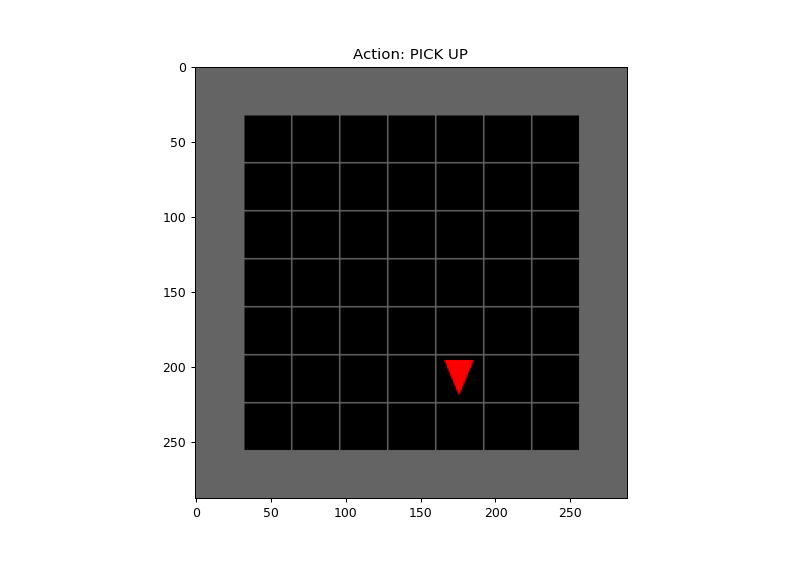

In [19]:
display_first_agent(display_env, first_agent, n_simulations=20)

# Second agent

### Don't change starting ball color

In [ ]:
first_agent = PPO.load("first_agent_v2", device="cpu")
second_env_kwargs ={"size": 9, "ball_color": "red", "tile_size": 8}
second_env = EmptyBallRoom(**second_env_kwargs)
second_env_vector_kwargs = {"env": second_env, "first_agent": first_agent}
test_env_second = HackedEnvironment(**second_env_vector_kwargs)
second_env_vector = make_vec_env(
    HackedEnvironment,
    n_envs=8,
    vec_env_cls=SubprocVecEnv,
    env_kwargs=second_env_vector_kwargs,
    monitor_dir="env_monitor")

### Change starting ball color

In [25]:
first_agent = PPO.load("first_agent_v2", device="cpu")
second_env_kwargs ={"size": 9, "ball_color": "red", "tile_size": 8}
second_env = RandomBallColorWrapper(EmptyBallRoom(**second_env_kwargs))
second_env_vector_kwargs = {"env": second_env, "first_agent": first_agent}
second_env_vector = make_vec_env(
    HackedEnvironment,
    n_envs=8,
    vec_env_cls=SubprocVecEnv,
    env_kwargs=second_env_vector_kwargs,
    monitor_dir="env_monitor")

### Train

In [6]:
policy_kwargs = dict(activation_fn=nn.ReLU)
second_agent = PPO(
    "CnnPolicy",
    second_env_vector,
    gamma=0.5,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log="second_agent_tb",
    ent_coef = 0
)


Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
second_agent.learn(
    total_timesteps=1_500_000,
    log_interval=1,
    n_eval_episodes=10,
    eval_env=test_env_second,
    eval_freq=10_000,
    eval_log_path="log/second_agent"
)
second_agent.save("second_agent")

## Dispaly second agent

In [88]:
def display_second_agent(env, model, n_simulations=10):
    ACTION_DICT = {0: "Turn left", 1: "Turn right", 2: "Forward", 3: "Pick up", 
                   4: "Drop", 5: "Toggle", 6: "Done"}
    
    
    fig, (ax1, ax2) = plt.subplots(figsize=(10,7 ), ncols=2)
    for i in range(n_simulations):
        state = env.reset()
        if i == 0:
            image1 = ax1.imshow(env.render("original", highlight=False))
            image2 = ax2.imshow(env.render("agent", highlight=False))
        else:
            image1.set_data(env.render("original", highlight=False))
            image2.set_data(env.render("agent", highlight=False))
        while True:
            action, _ = model.predict(state)
            state, r, done, _ = env.step(action)
            image1.set_data(env.render("original", highlight=False))
            image2.set_data(env.render("agent", highlight=False))
            ax1.set_title(f"{env.INDEX_TO_COLOR[env.transformation_action].upper()} to GREEN")
            ax2.set_title(f"Action: {ACTION_DICT[env.environment_action].upper()}")
            fig.canvas.draw()

            if done:
                break

In [93]:
second_env_kwargs ={"size": 9, "ball_color": "red", "tile_size": 8}
first_agent = PPO.load("second_agent", device="cpu")
second_env = RandomBallColorWrapper(EmptyBallRoom(**second_env_kwargs))

test_env = HackedEnvironment(second_env, first_agent)

<IPython.core.display.Javascript object>


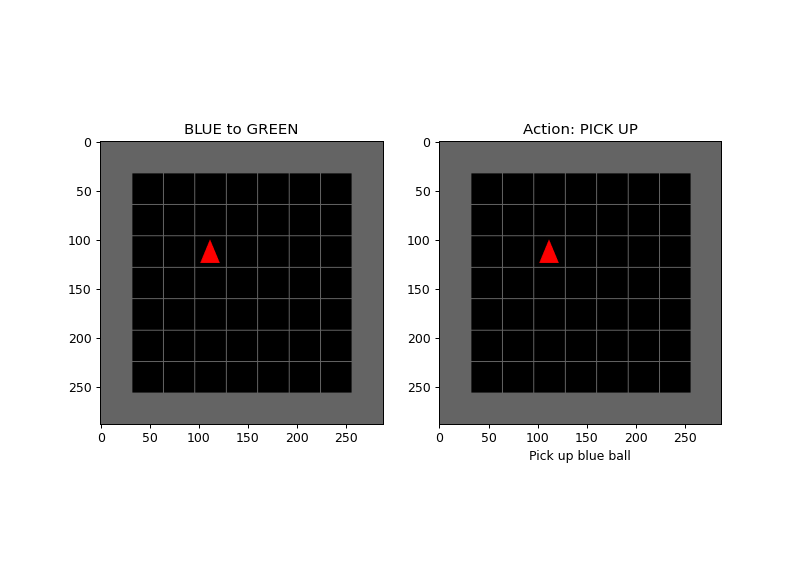

In [96]:
display_second_agent(test_env, second_agent)